In [1]:
%matplotlib inline
import numpy as np
from skyfield.api import load
from scipy.optimize import newton
from matplotlib import pyplot as plt
planets = load('de423.bsp')

In [2]:
class plutino:
    """
    generate plutinos
    units: au, radius
    
    """
    def __init__(self, size = 1000, mjd = 57023, e_c = 0.175, e_sigma = 0.06, i_sigma = 12,\
                 amp_c = 75, amp_max = 155, amp_min = 0):
        self.size = size
        self.mjd = mjd
        self.lambda_N = None
        self.neptune_lambda()
        self.a = self.gen_a()
        self.e = self.gen_e(e_c, e_sigma)
        self.i = self.gen_i(i_sigma)
        self.amp = self.gen_amp(amp_c, amp_max, amp_min)
        self.phi = self.gen_phi(self.amp)
        self.M = self.gen_M()
        self.node = self.gen_node()
        self.arg = self.gen_arg()
        self.H = self.gen_H()
        cut = (self.e > 0) * (~np.isnan(self.i))
        self.a = self.a[cut]
        self.e = self.e[cut]
        self.i = self.i[cut]
        self.amp = self.amp[cut]
        self.phi = self.phi[cut]
        self.M = self.M[cut]
        self.node = self.node[cut]
        self.arg = self.arg[cut]
        self.H = self.H[cut]
        X, Y, Z, r = zip(*map(self.kep_to_xyz, self.a, self.e, self.i,\
                                                  self.arg, self.node, self.M)) # r**2 = X**2 + Y**2 + Z**2
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.Z = np.array(Z)
        self.r = np.array(r)
        self.xyz_to_equa(self.X, self.Y, self.Z)
        self.H_to_mag()
        
    
    def gen_a(self):
        return 39.45 + np.random.random(self.size) * 0.4 - 0.2
        
    def gen_e(self, e_c, e_sigma):
        return np.random.normal(loc=e_c, scale=e_sigma, size = self.size)
        
    def gen_i(self, i_sigma):
        return np.arcsin(np.random.rayleigh(scale = i_sigma * np.pi/180., size = self.size))
        
    def gen_amp(self, amp_c, amp_max, amp_min):
        return np.random.triangular(amp_min, amp_c, amp_max, size = self.size) * np.pi / 180.
    
    def gen_phi(self, amp):
        return np.pi + amp * np.sin(2*np.pi*np.random.random(self.size)) 
        
    def gen_M(self):
        return 4*np.pi*np.random.random(self.size)
        
    def gen_node(self):
        return 2*np.pi*np.random.random(self.size) % (2*np.pi)
        
    def gen_arg(self):
        return (0.5*self.phi - 1.5*self.M - self.node + self.lambda_N) % (2*np.pi)
        
    def gen_H(self):
        alpha = 0.9
        h0 = 0
        h1 = 10
        h0s10 = 10**(alpha*h0)
        h1s10 = 10**(alpha*h1)
        return np.log10(np.random.random(self.size)*(h1s10-h0s10) + h0s10) / alpha
        
    def H_to_mag(self):
        phase = np.arccos((self.r**2 + self.delta**2 - self.earth_dis**2) / (2 * self.r * self.delta))
        phase_integral = 2/3. * ((1-phase/np.pi)*np.cos(phase) + 1/np.pi*np.sin(phase))
        self.mag = self.H + 2.5 * np.log10((self.r**2 * self.delta**2) / phase_integral)
        
    def neptune_lambda(self):
        neptune = planets[8]
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds        
        self.x_n, self.y_n, self.z_n = neptune.at(t).ecliptic_position().au
        self.lambda_N = np.arctan2(self.y_n, self.x_n) % (2*np.pi)

    def kep_to_xyz(self, a, e, i, arg, node, M):
        # compute eccentric anomaly
        f = lambda E, M, e: E - e * np.sin(E) - M
        E0 = M
        E = newton(f, E0, args=(M, e))
        # compute true anomaly
        v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
        # compute the barycentric distance
        r = a * (1 - e*np.cos(E))
        # compute X,Y,Z
        X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
        Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
        Z = r * (np.sin(i) * np.sin(arg + v))
        return X, Y, Z, r
        
    def xyz_to_equa(self, X0, Y0, Z0):
        earth = planets['earth']
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds
        epsilon =  23.43694 * np.pi/180.
        x_earth, y_earth, z_earth = earth.at(t).position.au
        self.earth_dis = (x_earth**2 + y_earth**2 + z_earth**2)**0.5
        X = X0 - x_earth
        Y = Y0 * np.cos(epsilon) - Z0 * np.sin(epsilon)  - y_earth
        Z = Y0 * np.sin(epsilon) + Z0 * np.cos(epsilon) - z_earth
        self.delta = (X**2 + Y**2+ Z**2)**0.5
        self.dec = np.arcsin(Z/(X**2+Y**2+Z**2)**0.5)
        self.ra = np.arctan2(Y, X) % (2*np.pi)

        

In [3]:
p = plutino(size = 2000, mjd=58199, e_c = 0.3, e_sigma = 0.01, amp_c = 1, amp_max = 2, amp_min = 0, i_sigma=12)

28.75101572744494 -8.349304564736059 -0.4906588087988942


(array([ 89., 114.,  89.,  98.,  96., 100.,  97., 102., 123., 106.,  91.,
         90., 112., 106.,  98., 100., 101.,  96., 106.,  86.]),
 array([39.25028192, 39.27024216, 39.29020239, 39.31016263, 39.33012286,
        39.35008309, 39.37004333, 39.39000356, 39.4099638 , 39.42992403,
        39.44988427, 39.4698445 , 39.48980473, 39.50976497, 39.5297252 ,
        39.54968544, 39.56964567, 39.5896059 , 39.60956614, 39.62952637,
        39.64948661]),
 <a list of 20 Patch objects>)

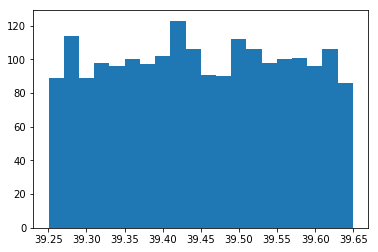

In [4]:
plt.hist(p.a, bins = 20)

(array([  1.,   5.,  16.,  34.,  54., 103., 159., 203., 256., 263., 256.,
        230., 168., 119.,  61.,  35.,  16.,  11.,   6.,   4.]),
 array([0.26665341, 0.27007615, 0.27349889, 0.27692164, 0.28034438,
        0.28376713, 0.28718987, 0.29061261, 0.29403536, 0.2974581 ,
        0.30088085, 0.30430359, 0.30772633, 0.31114908, 0.31457182,
        0.31799457, 0.32141731, 0.32484005, 0.3282628 , 0.33168554,
        0.33510829]),
 <a list of 20 Patch objects>)

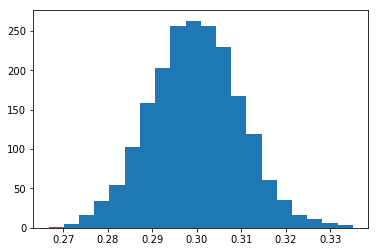

In [5]:
plt.hist(p.e, bins = 20)

(array([ 61., 130., 235., 269., 278., 236., 218., 158., 111.,  95.,  62.,
         54.,  33.,  24.,  14.,  10.,   5.,   3.,   1.,   3.]),
 array([ 0.19726516,  2.92585404,  5.65444292,  8.38303181, 11.11162069,
        13.84020957, 16.56879845, 19.29738734, 22.02597622, 24.7545651 ,
        27.48315399, 30.21174287, 32.94033175, 35.66892064, 38.39750952,
        41.1260984 , 43.85468728, 46.58327617, 49.31186505, 52.04045393,
        54.76904282]),
 <a list of 20 Patch objects>)

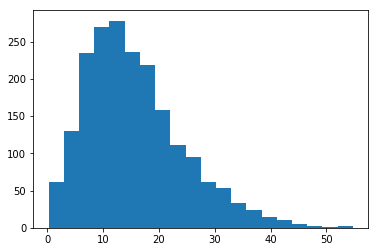

In [6]:
plt.hist(p.i*180/np.pi, bins = 20)

(array([   2.,    0.,    2.,    3.,    6.,   33.,   96.,  209.,  457.,
        1192.]),
 array([5.73493547, 6.16143677, 6.58793808, 7.01443939, 7.4409407 ,
        7.867442  , 8.29394331, 8.72044462, 9.14694593, 9.57344723,
        9.99994854]),
 <a list of 10 Patch objects>)

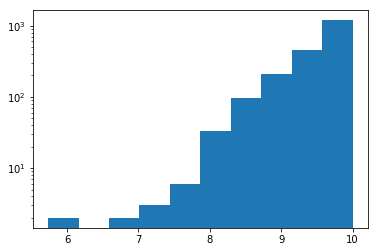

In [7]:
plt.yscale('log', bins = 20)
plt.hist(p.H)

(array([  1.,   1.,  12.,  43., 140., 282., 271., 344., 490., 416.]),
 array([21.60775298, 22.20741347, 22.80707395, 23.40673444, 24.00639492,
        24.60605541, 25.2057159 , 25.80537638, 26.40503687, 27.00469735,
        27.60435784]),
 <a list of 10 Patch objects>)

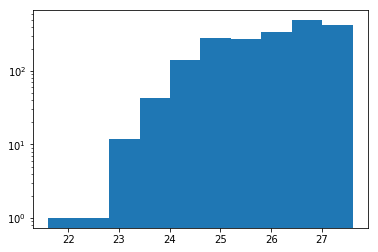

In [8]:
plt.yscale('log', bins = 20)
plt.hist(p.mag)

(array([ 93.,  84., 115.,  98., 101., 105., 100., 109.,  94., 106.,  91.,
         87., 100.,  91., 103., 108., 102., 108., 110.,  95.]),
 array([1.28313253e-03, 6.29364318e-01, 1.25744550e+00, 1.88552669e+00,
        2.51360787e+00, 3.14168906e+00, 3.76977024e+00, 4.39785143e+00,
        5.02593261e+00, 5.65401380e+00, 6.28209499e+00, 6.91017617e+00,
        7.53825736e+00, 8.16633854e+00, 8.79441973e+00, 9.42250091e+00,
        1.00505821e+01, 1.06786633e+01, 1.13067445e+01, 1.19348257e+01,
        1.25629068e+01]),
 <a list of 20 Patch objects>)

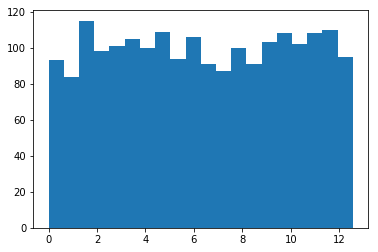

In [9]:
plt.hist(p.M, bins = 20)

(array([ 86., 104.,  98.,  96., 103., 108., 105., 107.,  88., 107., 112.,
        105., 105.,  97.,  86., 101.,  96.,  91., 103., 102.]),
 array([5.62183321e-03, 3.19342347e-01, 6.33062860e-01, 9.46783373e-01,
        1.26050389e+00, 1.57422440e+00, 1.88794491e+00, 2.20166543e+00,
        2.51538594e+00, 2.82910645e+00, 3.14282697e+00, 3.45654748e+00,
        3.77026799e+00, 4.08398851e+00, 4.39770902e+00, 4.71142953e+00,
        5.02515005e+00, 5.33887056e+00, 5.65259107e+00, 5.96631159e+00,
        6.28003210e+00]),
 <a list of 20 Patch objects>)

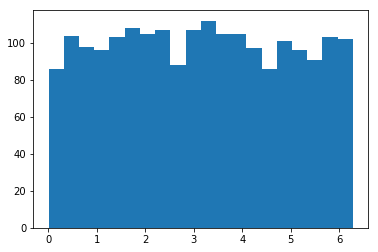

In [10]:
plt.hist(p.arg, bins = 20)

(array([103., 101., 101., 108.,  96.,  95.,  93., 109.,  98., 105., 106.,
        103.,  87., 111., 113.,  75.,  84., 100., 100., 112.]),
 array([1.15010204e-03, 3.15005156e-01, 6.28860209e-01, 9.42715262e-01,
        1.25657032e+00, 1.57042537e+00, 1.88428042e+00, 2.19813548e+00,
        2.51199053e+00, 2.82584558e+00, 3.13970064e+00, 3.45355569e+00,
        3.76741074e+00, 4.08126580e+00, 4.39512085e+00, 4.70897590e+00,
        5.02283096e+00, 5.33668601e+00, 5.65054106e+00, 5.96439612e+00,
        6.27825117e+00]),
 <a list of 20 Patch objects>)

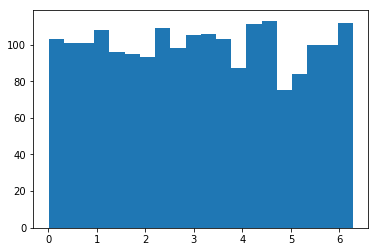

In [11]:
plt.hist(p.node, bins = 20)

(array([ 84., 102.,  91., 103.,  88., 114.,  79., 103., 120., 100., 101.,
        103.,  93., 105.,  86., 108., 117., 113.,  88., 102.]),
 array([2.87018047e-03, 3.16853014e-01, 6.30835847e-01, 9.44818680e-01,
        1.25880151e+00, 1.57278435e+00, 1.88676718e+00, 2.20075001e+00,
        2.51473285e+00, 2.82871568e+00, 3.14269851e+00, 3.45668135e+00,
        3.77066418e+00, 4.08464701e+00, 4.39862985e+00, 4.71261268e+00,
        5.02659551e+00, 5.34057834e+00, 5.65456118e+00, 5.96854401e+00,
        6.28252684e+00]),
 <a list of 20 Patch objects>)

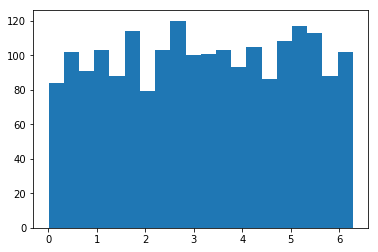

In [12]:
plt.hist((p.arg+p.node) % (2*np.pi), bins = 20)

(array([ 15.,  17.,  35.,  59., 106., 133., 127., 150., 169., 140., 183.,
        137., 173., 152., 114., 122.,  86.,  42.,  27.,  13.]),
 array([3.10868922, 3.11193216, 3.1151751 , 3.11841804, 3.12166098,
        3.12490392, 3.12814686, 3.1313898 , 3.13463275, 3.13787569,
        3.14111863, 3.14436157, 3.14760451, 3.15084745, 3.15409039,
        3.15733333, 3.16057627, 3.16381921, 3.16706216, 3.1703051 ,
        3.17354804]),
 <a list of 20 Patch objects>)

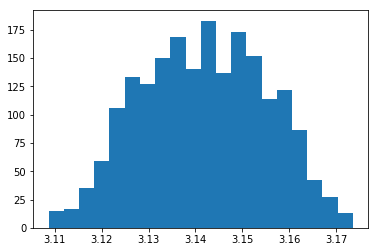

In [13]:
plt.hist(p.phi, bins = 20)

In [14]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [15]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

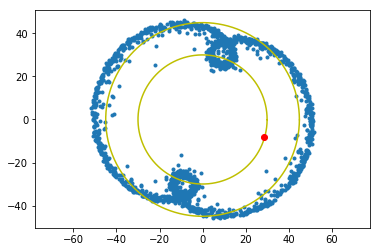

In [16]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(p.x_n, p.y_n, 'ro')

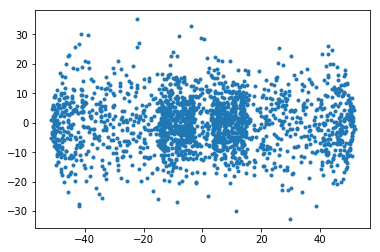

In [17]:
plt.axis('equal')
plt.scatter(p.X,p.Z, marker = '.')

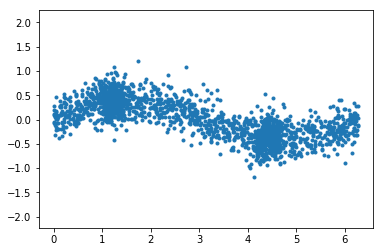

In [18]:
plt.axis('equal')
plt.scatter(p.ra,p.dec, marker = '.')